In [1]:
# imports
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import h5py
import matplotlib.pyplot as plt
import cv2
import utilitary as util
import keras
from keras.callbacks import ModelCheckpoint

%load_ext autoreload

In [2]:
hf = h5py.File("../dataset2.h5", "r")

In [3]:
keys = hf.keys()
use_key = util.remove_empty_key(hf, keys)

# removes entries with 1 contour (impossible to rotate atm)
del use_key[184]
del use_key[459]

x,y,z = hf.get('0')['frame'][0].shape

       
nb_entries = len(use_key) 

In [101]:
# Store the red & green channels in numpy array to be able to calculate max & min
red = np.empty((len(use_key), x, y, z), dtype=np.uint16)

for i, key in enumerate(use_key):
    red[i] = hf.get(key)['frame'][0]

max_r = np.max(red)
min_r = np.min(red)
del red

green = np.empty((len(use_key), x, y, z), dtype=np.uint16)

for i, key in enumerate(use_key):
    green[i] = hf.get(key)['frame'][1]
max_g = np.max(green)
min_g = np.min(green)
del green



In [7]:
max_r = 1543
min_r = 0
max_g = 1760
min_g = 0

In [51]:
# Find the mask of every frame of the red channel and apply it on the green channel 
g_masked = np.empty((len(use_key), x, y, z), dtype=np.float32)

for i, key in enumerate(use_key):
    red = hf.get(key)['frame'][0]
    red = red.astype('float32') 
    red = cv2.medianBlur(red, 5)
    mask_red = red > 130
    
    green = hf.get(key)['frame'][1]
    green = green.astype('float32') 
    green = cv2.medianBlur(green, 5)
    g_masked[i,...] = green * mask_red


In [52]:
# MIP the red and the green channel
r_MIP, _ = util.MIP_GR(hf, use_key, axis = 2)
g_MIP = util.np_MIP(g_masked, use_key, axis = 2)

In [11]:
# Save the MIP to avoid loosing 2mn30 each time
np.save('red.npy', r_MIP)
np.save('green.npy', g_MIP)

In [26]:
r_MIP = np.load('red.npy')
g_MIP = np.load('green.npy')

In [27]:
# contours of the red channel
MIP_ctr, _, ctr_list = util.find_contour(r_MIP, blur=5)

In [28]:
#rotated image and rotated contour
rotated_img = [
    util.rot_img(r_MIP[i], 
                 MIP_ctr[i],
                 ctr_list[i]) for i in range(len(use_key))
    ]

rotated_gr = [
    util.rot_img(g_MIP[i], 
                 MIP_ctr[i],
                 ctr_list[i]) for i in range(len(use_key))
    ]

#contain the image cropped around the contour center of mass
cropped_img = [util.crop_ctr_mass(rotated_img[i]) for i in range(len(use_key))]

cropped_gre = [util.crop_ctr_mass(rotated_gr[i]) for i in range(len(use_key))]

In [29]:
# Save the MIP to avoid loosing 2mn30 each time
np.save('crop_r.npy', cropped_img)
np.save('crop_g.npy', cropped_gre)

In [4]:
cropped_img = np.load('crop_r.npy')
cropped_gre = np.load('crop_g.npy')

In [13]:
# Split train-validation set
# 90% train  - 10% test
ratio = 0.9
keys_random = np.random.permutation(nb_entries)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]

In [14]:
# generate train set on red normalized channel
slices_train_r = np.array([(cropped_img[i]-min_r)/(max_r-min_r) for i in keys_train])

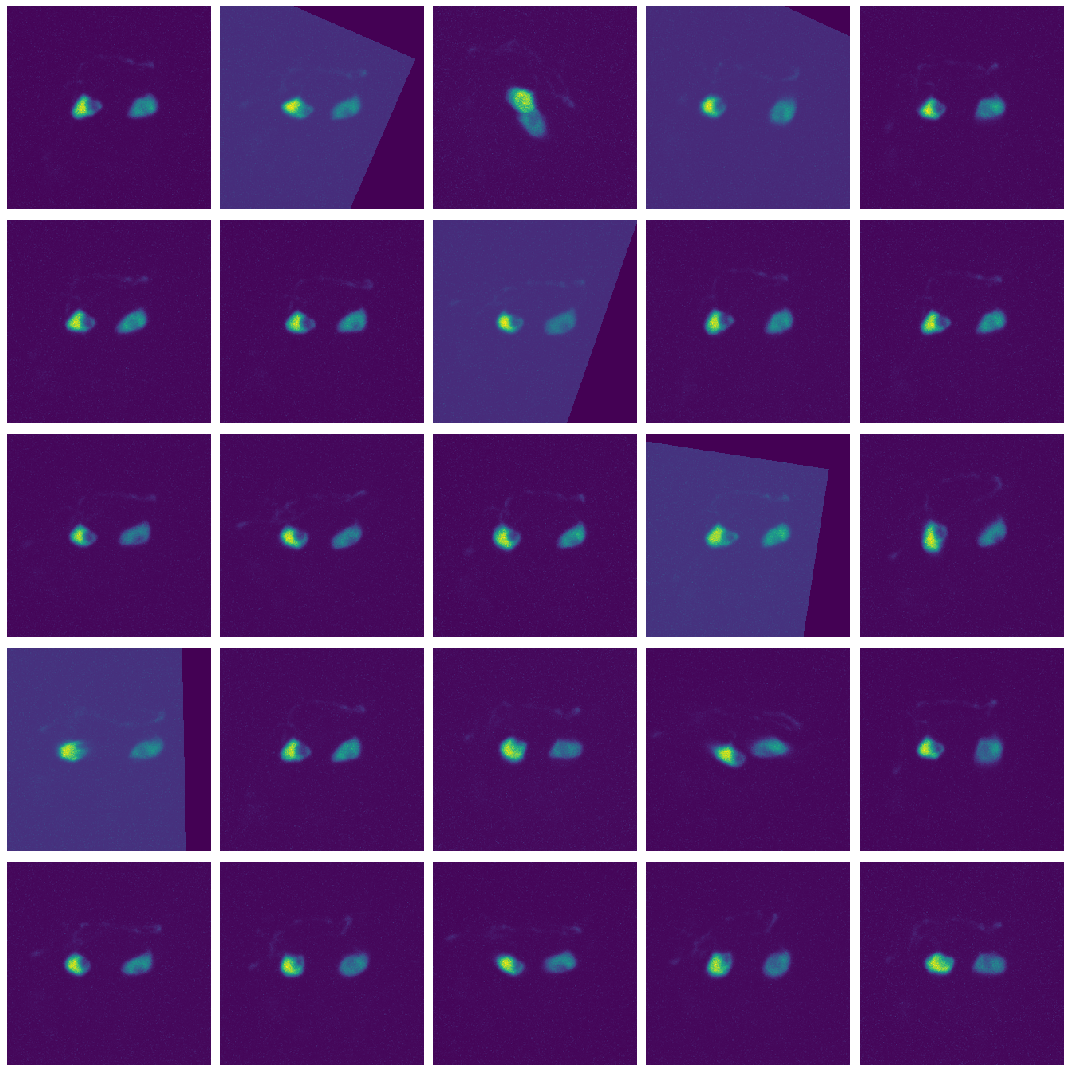

In [8]:
#have a look at some random entries
j, k = 5, 5
idx = np.linspace(0, 300, 300)
l = 7
ne.plot.slices([slices_train_r[int(i)] for i in idx[0+l*25:(l+1)*25]], do_colorbars=True, grid = [k,j]);


In [15]:
# UNET architecture

vol_shape = slices_train_r[0].shape
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

In [17]:
# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambda_ = 0.05

loss_weights = [1, lambda_]

# Adam optimizer learning rate
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)


checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
                             save_best_only=True, mode='auto', period=1)

# out of the training data, 29 are chosen to be for validation
train_generator = util.vxm_data_generator(slices_train_r[30:], 12, batch_size = 16)
val = util.create_xy(slices_train_r[:30], 3)

hist = vxm_model.fit(train_generator, validation_data=val, epochs=90, 
                     steps_per_epoch=slices_train_r.shape[0]//16, verbose=1, 
                     validation_batch_size = 16, callbacks=[checkpoint])


# Visualize the losses
util.plot_history(hist, lambda_, loss_name=['loss','val_loss'], save_name = 'title')

Epoch 1/90
32/32 [==============================] - ETA: 0s - loss: 7.2440e-04 - vxm_dense_transformer_loss: 7.2286e-04 - vxm_dense_flow_loss: 3.0971e-05WARNING:tensorflow:5 out of the last 17 calls to <function Model.make_test_function.<locals>.test_function at 0x7ff4e44c6af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

Epoch 00001: loss improved from inf to 0.00072, saving model to best_model.hdf5
32/32 [=======

Epoch 17/90
32/32 [==============================] - ETA: 0s - loss: 4.1705e-04 - vxm_dense_transformer_loss: 3.3169e-04 - vxm_dense_flow_loss: 0.0017
Epoch 00017: loss did not improve from 0.00041
32/32 [==============================] - 111s 3s/step - loss: 4.1705e-04 - vxm_dense_transformer_loss: 3.3169e-04 - vxm_dense_flow_loss: 0.0017 - val_loss: 8.6471e-04 - val_vxm_dense_transformer_loss: 7.3696e-04 - val_vxm_dense_flow_loss: 0.0026
Epoch 18/90
32/32 [==============================] - ETA: 0s - loss: 3.9023e-04 - vxm_dense_transformer_loss: 3.1069e-04 - vxm_dense_flow_loss: 0.0016
Epoch 00018: loss improved from 0.00041 to 0.00039, saving model to best_model.hdf5
32/32 [==============================] - 111s 3s/step - loss: 3.9023e-04 - vxm_dense_transformer_loss: 3.1069e-04 - vxm_dense_flow_loss: 0.0016 - val_loss: 8.3363e-04 - val_vxm_dense_transformer_loss: 6.9498e-04 - val_vxm_dense_flow_loss: 0.0028
Epoch 19/90
32/32 [==============================] - ETA: 0s - loss: 4.0825

32/32 [==============================] - ETA: 0s - loss: 3.9480e-04 - vxm_dense_transformer_loss: 3.0915e-04 - vxm_dense_flow_loss: 0.0017
Epoch 00035: loss did not improve from 0.00037
32/32 [==============================] - 89s 3s/step - loss: 3.9480e-04 - vxm_dense_transformer_loss: 3.0915e-04 - vxm_dense_flow_loss: 0.0017 - val_loss: 7.7707e-04 - val_vxm_dense_transformer_loss: 6.2309e-04 - val_vxm_dense_flow_loss: 0.0031
Epoch 36/90
32/32 [==============================] - ETA: 0s - loss: 3.9970e-04 - vxm_dense_transformer_loss: 3.1549e-04 - vxm_dense_flow_loss: 0.0017
Epoch 00036: loss did not improve from 0.00037
32/32 [==============================] - 89s 3s/step - loss: 3.9970e-04 - vxm_dense_transformer_loss: 3.1549e-04 - vxm_dense_flow_loss: 0.0017 - val_loss: 7.8719e-04 - val_vxm_dense_transformer_loss: 6.2452e-04 - val_vxm_dense_flow_loss: 0.0033
Epoch 37/90
32/32 [==============================] - ETA: 0s - loss: 4.0360e-04 - vxm_dense_transformer_loss: 3.1761e-04 - vxm

Epoch 54/90
32/32 [==============================] - ETA: 0s - loss: 3.8271e-04 - vxm_dense_transformer_loss: 3.0097e-04 - vxm_dense_flow_loss: 0.0016
Epoch 00054: loss did not improve from 0.00037
32/32 [==============================] - 90s 3s/step - loss: 3.8271e-04 - vxm_dense_transformer_loss: 3.0097e-04 - vxm_dense_flow_loss: 0.0016 - val_loss: 7.6036e-04 - val_vxm_dense_transformer_loss: 5.9516e-04 - val_vxm_dense_flow_loss: 0.0033
Epoch 55/90
32/32 [==============================] - ETA: 0s - loss: 3.9777e-04 - vxm_dense_transformer_loss: 3.1591e-04 - vxm_dense_flow_loss: 0.0016
Epoch 00055: loss did not improve from 0.00037
32/32 [==============================] - 90s 3s/step - loss: 3.9777e-04 - vxm_dense_transformer_loss: 3.1591e-04 - vxm_dense_flow_loss: 0.0016 - val_loss: 7.5851e-04 - val_vxm_dense_transformer_loss: 6.0003e-04 - val_vxm_dense_flow_loss: 0.0032
Epoch 56/90
32/32 [==============================] - ETA: 0s - loss: 3.8506e-04 - vxm_dense_transformer_loss: 2.99

32/32 [==============================] - ETA: 0s - loss: 3.5564e-04 - vxm_dense_transformer_loss: 2.7273e-04 - vxm_dense_flow_loss: 0.0017
Epoch 00072: loss did not improve from 0.00031
32/32 [==============================] - 91s 3s/step - loss: 3.5564e-04 - vxm_dense_transformer_loss: 2.7273e-04 - vxm_dense_flow_loss: 0.0017 - val_loss: 7.6095e-04 - val_vxm_dense_transformer_loss: 5.9027e-04 - val_vxm_dense_flow_loss: 0.0034
Epoch 73/90
32/32 [==============================] - ETA: 0s - loss: 3.7119e-04 - vxm_dense_transformer_loss: 2.8524e-04 - vxm_dense_flow_loss: 0.0017
Epoch 00073: loss did not improve from 0.00031
32/32 [==============================] - 90s 3s/step - loss: 3.7119e-04 - vxm_dense_transformer_loss: 2.8524e-04 - vxm_dense_flow_loss: 0.0017 - val_loss: 7.5576e-04 - val_vxm_dense_transformer_loss: 5.8145e-04 - val_vxm_dense_flow_loss: 0.0035
Epoch 74/90
32/32 [==============================] - ETA: 0s - loss: 3.6657e-04 - vxm_dense_transformer_loss: 2.8072e-04 - vxm

TypeError: plot_history() missing 1 required positional argument: 'param'

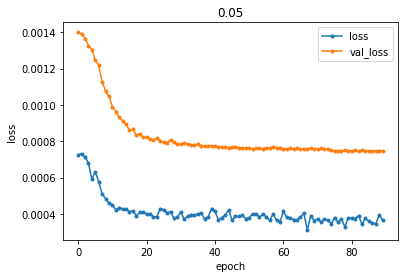

In [18]:
util.plot_history(hist, lambda_, loss_name=['loss','val_loss'], save_name = 'title')

In [ ]:
title = "w_test90" + str(lambda_) + ".keras"
# If it looks ok => save the weights
vxm_model.save_weights(title)

In [ ]:
### RED CANAL

# Regularizer
#lambdas = np.logspace(-5,-2,3)
# Load the best weights found
title = 'wght_3d_0.0005.keras' #"best_model.hdf5"
vxm_model.load_weights(title)

# Validation set generator
val_generator = util.vxm_data_generator(slices_test_r, 3, batch_size = 30)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

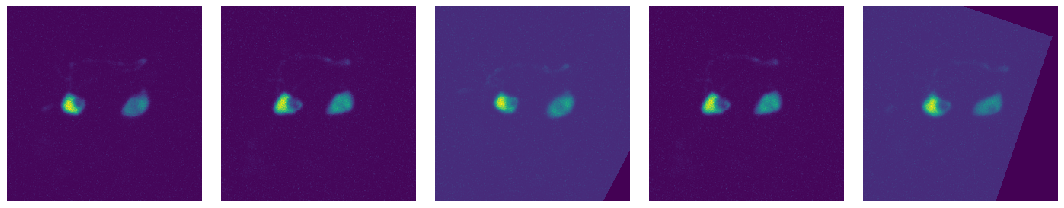

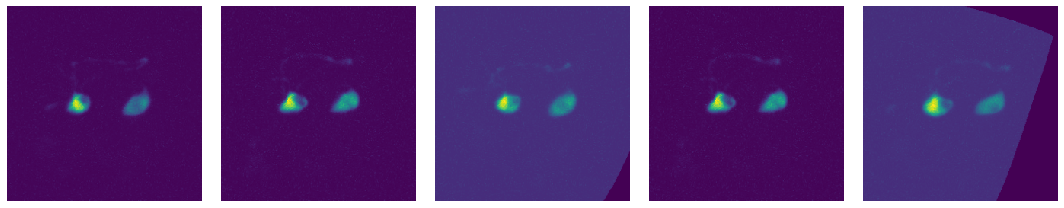

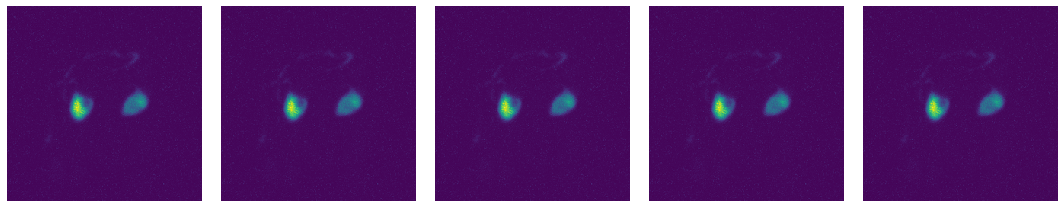

In [72]:
moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]
c = [fixed[i, ...] for i in range(5)]

print()
# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);
# Fixed
ne.plot.slices(c, do_colorbars=True);